<a href="https://colab.research.google.com/github/Ikhtiyor31/Deep-Learning/blob/master/Cats_vs_Dogs_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to build an image classifier using `tf.keras.Sequential` model and to load data using `tf.keras.preprocessing.image.ImageDataGenerator`.


* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class — How can we efficiently work with data on disk to interface with our model?
* _Overfitting_ - what is it, how to identify it, and how can we prevent it?
* _Data Augmentation_ and _Dropout_ - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.

## model building workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process

<hr>



importing required packages

*   os - to read files and directories
*   numpy - for some matrix math  operation of TensorFlow
*   matplotlib.pyplot  - to plot the graph and display images in our training and validation data




In [27]:
from __future__ import absolute_import, division, print_function

import os 
import matplotlib.pyplot as plt
import numpy as np


In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

To build image classifier, we download the dataset. The dataset we are using is a filtered version of `Dogs and Cats` dataset from Kaggle(ultimately, this dataset is provided by Microsoft Research).

In [29]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

to print directory and see

In [30]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


assign variables with the proper file path for the training and validation sets.

In [31]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats') # directories with  training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # directories with training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # directories with validation cats pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # directories with validation dogs picture

to check how many cats and dogs images we have in training and validation directories.


In [32]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print(total_train)
print(total_val)

2000
1000


**Setting Model Parameters**

In [33]:
batch_size = 100 # number of training examples to process before updating our models variables
image_shape = 150 # training example data consists of images with width of 150 and heights of 150

**Data Preparation**

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network.The steps invloved in preparing these images
1. Read Image from Disk
2. Decode the content of images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to value between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be one using the class **tf.keras.preprocessing.image.imageDataGenenrator**

In [34]:
#train_image_generator = ImageDataGenerator(rescale=1./255)# generator for training data
#validation_image_generator = ImageDataGenerator(rescale=1./255) # generator for validation data

After defining our generators for training and validation images, **flow_from_directory method will load images from the disk, apply rescaling and resizing them using single line of code.

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [35]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Flipping the image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [36]:
train_image_generator =ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size, directory=train_dir,
    shuffle=True, target_size=(image_shape, image_shape), # 150 x 150
class_mode='binary')

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

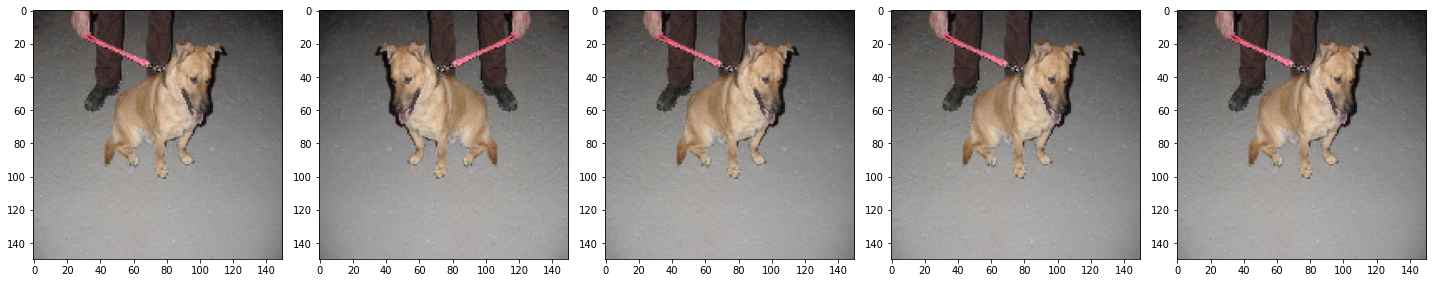

In [37]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Rotating the images

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [38]:
image_gen  = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(image_shape, image_shape),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


To see the transformation in action

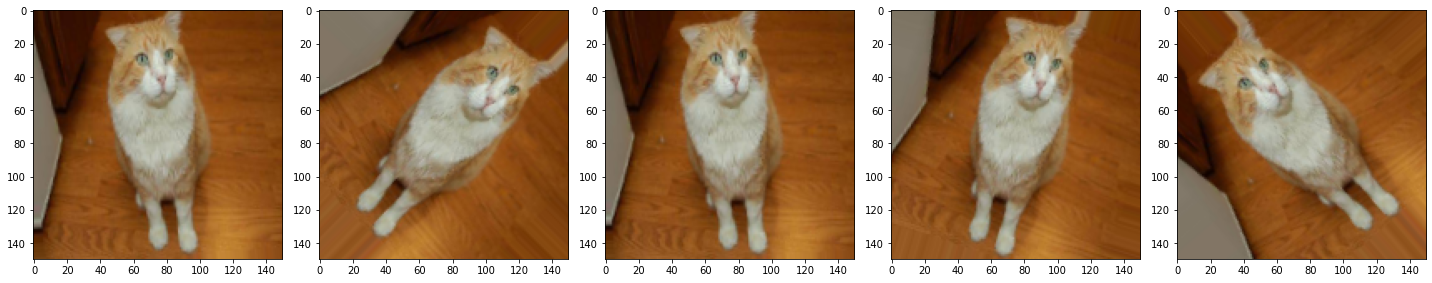

In [39]:
rotated_image = [train_data_gen[0][0][0] for i in range(5)]
plotImages(rotated_image)

In [40]:
validation_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    shuffle=True,
    target_size=(image_shape, image_shape), # 150 x 150
    class_mode='binary')


Found 1000 images belonging to 2 classes.


# Applying Zoom

applying zoom augmentation to our dataset, zooming images up to 50% randomly

In [42]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(image_shape, image_shape),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


to check the transformation effect 

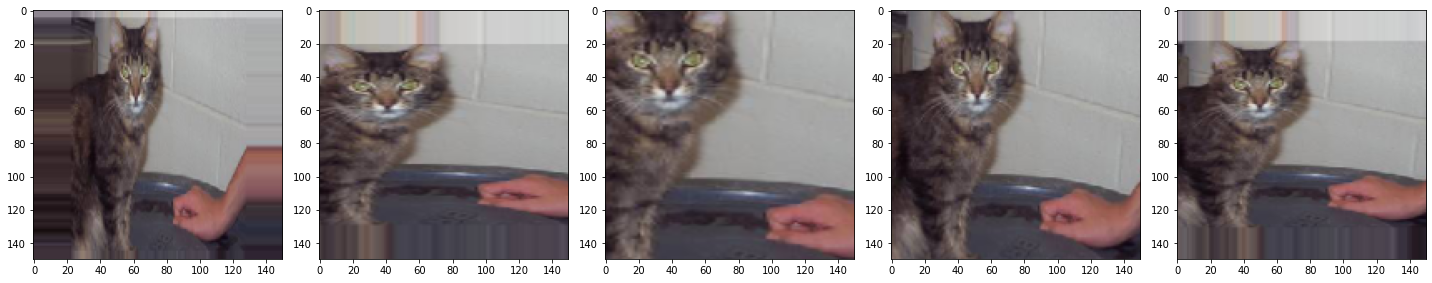

In [18]:
zoomed_image  = [train_data_gen[0][0][0] for i in range(5)]
plotImages(zoomed_image)

**Visualizing Training images**

We can visualize the training images by getting a batch of images from the training generator and the plotting a few of them using matplotlib

In [43]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(image_shape,image_shape),
                                                     class_mode='binary')
sample_training_image, _ = next(train_data_gen)

Found 2000 images belonging to 2 classes.


The `next` function returns a batch from the dataset, One batch is tuple of (many images, many labels). For right now, we're discarding the labels because we jst want to look at the images.

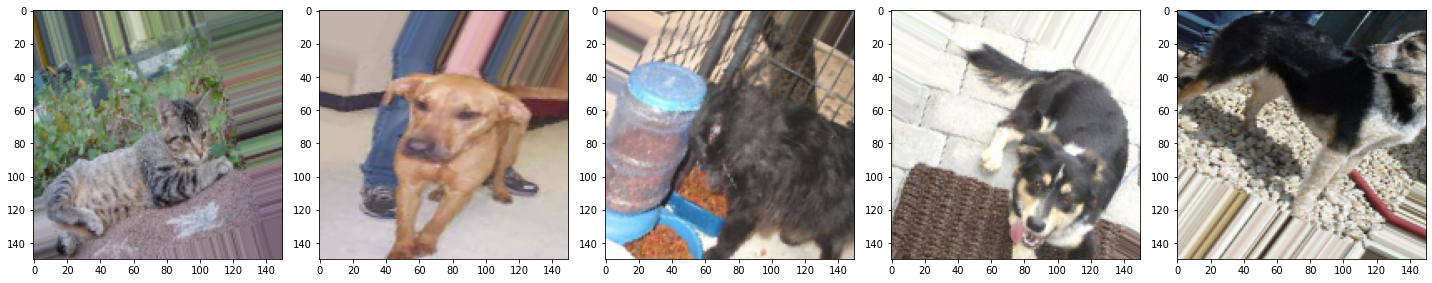

In [44]:
plotImages(sample_training_image[:5])

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [68]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [69]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)      

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [71]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

Epoch 1/100
20/20 [==============================] - 16s 780ms/step - loss: 0.7393 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 15s 761ms/step - loss: 0.6933 - accuracy: 0.5035 - val_loss: 0.6930 - val_accuracy: 0.5670
Epoch 3/100
20/20 [==============================] - 15s 762ms/step - loss: 0.6931 - accuracy: 0.5365 - val_loss: 0.6919 - val_accuracy: 0.5080
Epoch 4/100
20/20 [==============================] - 15s 767ms/step - loss: 0.6930 - accuracy: 0.5165 - val_loss: 0.6912 - val_accuracy: 0.5110
Epoch 5/100
20/20 [==============================] - 15s 766ms/step - loss: 0.6898 - accuracy: 0.5560 - val_loss: 0.7209 - val_accuracy: 0.5080
Epoch 6/100
20/20 [==============================] - 15s 762ms/step - loss: 0.6925 - accuracy: 0.5395 - val_loss: 0.6900 - val_accuracy: 0.5550
Epoch 7/100
20/20 [==============================] - 15s 768ms/step - loss: 0.6863 - accuracy: 0.5255 - val_loss: 0.6698 - val_accuracy:

### Visualizing results of the training

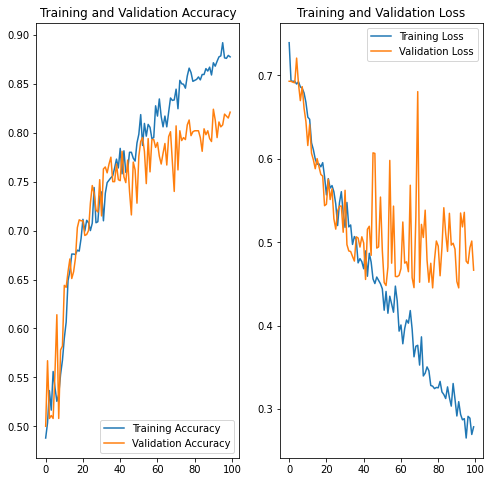

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

#Techniques to Prevent Overfitting

* **Early Stopping**: In this method, we track the loss on the validation set during the training phase and use it to determine when to stop training such that the model is accurate but not overfitting.
* **Image Augmentation:** Artificially boosting the number of images in our training set by applying random image transformations to the existing images in the training set.
* **Dropout:** Removing a random selection of a fixed number of neurons in a neural network during training.